In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install pandas numpy pillow scikit-learn matplotlib seaborn timm

Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 121.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s e

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/FF.zip

Streaming output truncated to the last 5000 lines.
  inflating: FF++(HQ)/masked_extracted_frames/Face2Face/Face2Face_204_230_frame_290_341x306.jpg  
  inflating: __MACOSX/FF++(HQ)/masked_extracted_frames/Face2Face/._Face2Face_204_230_frame_290_341x306.jpg  
  inflating: FF++(HQ)/masked_extracted_frames/Face2Face/Face2Face_920_811_frame_110_345x311.jpg  
  inflating: __MACOSX/FF++(HQ)/masked_extracted_frames/Face2Face/._Face2Face_920_811_frame_110_345x311.jpg  
  inflating: FF++(HQ)/masked_extracted_frames/Face2Face/Face2Face_170_186_frame_40_370x335.jpg  
  inflating: __MACOSX/FF++(HQ)/masked_extracted_frames/Face2Face/._Face2Face_170_186_frame_40_370x335.jpg  
  inflating: FF++(HQ)/masked_extracted_frames/Face2Face/Face2Face_812_821_frame_260_152x142.jpg  
  inflating: __MACOSX/FF++(HQ)/masked_extracted_frames/Face2Face/._Face2Face_812_821_frame_260_152x142.jpg  
  inflating: FF++(HQ)/masked_extracted_frames/Face2Face/Face2Face_696_686_frame_80_125x99.jpg  
  inflating: __MACOSX/FF++(

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchvision import models
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(
        f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

# Set paths
BASE_PATH = '/content/FF++(HQ)'  # Adjust this path
CSV_PATH = os.path.join(BASE_PATH, 'FF++(HQ)_CSV')
MODELS_PATH = '/content/models'
os.makedirs(MODELS_PATH, exist_ok=True)

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 39.6 GB


In [5]:
class DeepfakeDataset(Dataset):
    def __init__(self, csv_file, base_path=BASE_PATH, transform=None, max_samples=None):
        """Enhanced dataset with better error handling"""
        self.data_frame = pd.read_csv(csv_file)
        self.base_path = base_path
        self.transform = transform

        if max_samples:
            self.data_frame = self.data_frame.head(max_samples)

        print(f"Dataset loaded with {len(self.data_frame)} samples")

        # Check class distribution
        class_counts = self.data_frame.iloc[:, 1].value_counts()
        print(f"Class distribution: {dict(class_counts)}")

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.data_frame.iloc[idx, 0]
        label = self.data_frame.iloc[idx, 1]

        # Clean the path
        img_path = img_path.replace(
            "/homepool/k2307212/DeepFakeDetection/backup/Backup_to_my_phd_data/E/Nour/", "")
        full_img_path = os.path.join(self.base_path, img_path)

        try:
            image = Image.open(full_img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {full_img_path}: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)
        return image, label


# Enhanced data augmentation for better robustness
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3,
                           saturation=0.3, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3))
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Attention mechanism for enhanced model


class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        query = self.query(x).view(
            batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, width * height)
        value = self.value(x).view(batch_size, -1, width * height)

        attention = torch.bmm(query, key)
        attention = self.softmax(attention)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)

        return self.gamma * out + x

# Enhanced DeepfakeDetector with ResNet152 and attention


class EnhancedDeepfakeDetector(nn.Module):
    def __init__(self, num_classes=2, use_attention=True):
        super(EnhancedDeepfakeDetector, self).__init__()

        # Use ResNet152 as requested by professor
        self.backbone = models.resnet152(pretrained=True)

        # Freeze early layers for better transfer learning
        for param in list(self.backbone.parameters())[:-50]:
            param.requires_grad = False

        # Get feature dimensions
        num_features = self.backbone.fc.in_features

        # Add attention mechanism if requested
        self.use_attention = use_attention
        if use_attention:
            self.attention = SelfAttention(2048)  # ResNet152 has 2048 features

        # Enhanced classifier with more regularization
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Extract features before the final pooling
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # Apply attention if enabled
        if self.use_attention:
            x = self.attention(x)

        # Global average pooling and classification
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.backbone.fc(x)

        return x

# Data splitting function with new ratios (50% train, 30% val, 20% test)


def create_data_splits(dataset, train_ratio=0.5, val_ratio=0.3, test_ratio=0.2):
    """Create data splits with professor's requested ratios"""
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(
        f"Data split - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
    return train_dataset, val_dataset, test_dataset

# Real-time epoch visualization function


def plot_epoch_progress(train_losses, val_losses, train_accs, val_accs, current_epoch, save_plots=True):
    """Display real-time training progress for each epoch"""
    clear_output(wait=True)

    plt.figure(figsize=(20, 12))
    epochs = range(1, len(train_losses) + 1)

    # Plot 1: Loss Progress
    plt.subplot(2, 4, 1)
    plt.plot(epochs, train_losses, 'b-',
             label='Training Loss', linewidth=2, marker='o')
    plt.plot(epochs, val_losses, 'r-',
             label='Validation Loss', linewidth=2, marker='s')
    plt.title(
        f'Loss Progress - Epoch {current_epoch}', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Accuracy Progress
    plt.subplot(2, 4, 2)
    plt.plot(epochs, train_accs, 'b-',
             label='Training Accuracy', linewidth=2, marker='o')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy',
             linewidth=2, marker='s')
    plt.title(
        f'Accuracy Progress - Epoch {current_epoch}', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Learning Curve
    plt.subplot(2, 4, 3)
    plt.plot(epochs, train_losses, 'b-', linewidth=2, label='Train Loss')
    plt.plot(epochs, [1-acc for acc in train_accs],
             'b--', linewidth=2, label='Train Error')
    plt.plot(epochs, val_losses, 'r-', linewidth=2, label='Val Loss')
    plt.plot(epochs, [1-acc for acc in val_accs],
             'r--', linewidth=2, label='Val Error')
    plt.title(
        f'Learning Curve - Epoch {current_epoch}', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Error')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 4: Current Performance Metrics
    plt.subplot(2, 4, 4)
    if len(train_losses) > 0:
        current_metrics = ['Train\nLoss', 'Val\nLoss',
                           'Train\nAcc', 'Val\nAcc', 'Best\nVal Acc']
        current_values = [train_losses[-1], val_losses[-1],
                          train_accs[-1], val_accs[-1], max(val_accs)]
        colors = ['lightblue', 'lightcoral', 'blue', 'red', 'gold']

        bars = plt.bar(current_metrics, current_values,
                       color=colors, alpha=0.8)
        plt.title(
            f'Current Metrics - Epoch {current_epoch}', fontsize=14, fontweight='bold')
        plt.ylabel('Value')
        plt.ylim(0, 1)

        for bar, value in zip(bars, current_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                     f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Plot 5: Overfitting Analysis
    plt.subplot(2, 4, 5)
    if len(train_accs) > 0:
        gap = [abs(t_acc - v_acc)
               for t_acc, v_acc in zip(train_accs, val_accs)]
        plt.plot(epochs, gap, 'g-', linewidth=2,
                 marker='d', label='Train-Val Gap')
        plt.title(
            f'Overfitting Analysis - Epoch {current_epoch}', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Gap')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Plot 6: Best Performance Highlight
    plt.subplot(2, 4, 6)
    if len(val_accs) > 0:
        best_epoch = val_accs.index(max(val_accs)) + 1
        plt.plot(epochs, val_accs, 'r-', linewidth=2,
                 label='Validation Accuracy')
        plt.scatter([best_epoch], [max(val_accs)], color='gold', s=100, zorder=5,
                    label=f'Best Epoch {best_epoch}')
        plt.title(
            f'Best Performance - Epoch {current_epoch}', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Validation Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Plot 7: Loss Smoothing (Moving Average)
    plt.subplot(2, 4, 7)
    if len(train_losses) >= 3:
        # Calculate moving average for smoother visualization
        window = min(3, len(train_losses))
        train_smooth = np.convolve(
            train_losses, np.ones(window)/window, mode='valid')
        val_smooth = np.convolve(
            val_losses, np.ones(window)/window, mode='valid')
        smooth_epochs = range(window, len(train_losses) + 1)

        plt.plot(smooth_epochs, train_smooth, 'b-',
                 linewidth=2, label='Train Loss (Smooth)')
        plt.plot(smooth_epochs, val_smooth, 'r-',
                 linewidth=2, label='Val Loss (Smooth)')
        plt.title(
            f'Smoothed Loss - Epoch {current_epoch}', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Plot 8: Performance Summary Table
    plt.subplot(2, 4, 8)
    plt.axis('off')
    if len(train_losses) > 0:
        summary_data = [
            ['Metric', 'Value'],
            ['Current Epoch', f'{current_epoch}'],
            ['Train Loss', f'{train_losses[-1]:.4f}'],
            ['Val Loss', f'{val_losses[-1]:.4f}'],
            ['Train Acc', f'{train_accs[-1]:.4f}'],
            ['Val Acc', f'{val_accs[-1]:.4f}'],
            ['Best Val Acc', f'{max(val_accs):.4f}'],
            ['Best Epoch', f'{val_accs.index(max(val_accs)) + 1}'],
            ['Overfitting Gap', f'{abs(train_accs[-1] - val_accs[-1]):.4f}']
        ]

        table = plt.table(cellText=summary_data,
                          cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        plt.title(f'Summary - Epoch {current_epoch}',
                  fontsize=14, fontweight='bold', pad=20)

    plt.suptitle(
        f'Real-Time Training Progress - Epoch {current_epoch}', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Save plot for each epoch if requested
    if save_plots:
        plt.savefig(
            f'/content/epoch_{current_epoch:03d}_progress.png', dpi=300, bbox_inches='tight')

    plt.show()

    # Print detailed epoch summary
    if len(train_losses) > 0:
        print(f"\n{'='*100}")
        print(f"EPOCH {current_epoch} DETAILED SUMMARY")
        print(f"{'='*100}")
        print(f"📊 Current Performance:")
        print(f"   Training Loss:     {train_losses[-1]:.6f}")
        print(f"   Validation Loss:   {val_losses[-1]:.6f}")
        print(
            f"   Training Accuracy: {train_accs[-1]:.6f} ({train_accs[-1]*100:.2f}%)")
        print(
            f"   Validation Accuracy: {val_accs[-1]:.6f} ({val_accs[-1]*100:.2f}%)")
        print(f"🏆 Best Performance:")
        print(
            f"   Best Val Accuracy: {max(val_accs):.6f} ({max(val_accs)*100:.2f}%)")
        print(f"   Best Epoch:        {val_accs.index(max(val_accs)) + 1}")
        print(f"📈 Training Analysis:")
        print(
            f"   Overfitting Gap:   {abs(train_accs[-1] - val_accs[-1]):.6f}")
        print(
            f"   Loss Improvement:  {'✓' if len(val_losses) == 1 or val_losses[-1] < val_losses[-2] else '✗'}")
        print(
            f"   Acc Improvement:   {'✓' if len(val_accs) == 1 or val_accs[-1] > val_accs[-2] else '✗'}")
        print(f"{'='*100}")

# Enhanced training function with real-time visualization


def train_enhanced_model(model, train_loader, val_loader, num_epochs=20, initial_lr=0.001, show_realtime_plots=True):
    model.to(device)

    # Enhanced loss function with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Advanced optimizer with better parameters
    optimizer = optim.AdamW(model.parameters(), lr=initial_lr,
                            weight_decay=0.02, betas=(0.9, 0.999))

    # Cosine annealing scheduler for better convergence
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=1e-6
    )

    # Early stopping parameters
    best_val_acc = 0.0
    patience = 7
    patience_counter = 0

    # Metrics storage
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    print(f"Starting enhanced training for {num_epochs} epochs...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(
        f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            if batch_idx % 20 == 0:
                current_acc = train_correct / train_total if train_total > 0 else 0
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, Acc: {current_acc:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_predictions, val_targets = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        # Calculate metrics
        train_accuracy = train_correct / train_total
        val_accuracy = accuracy_score(val_targets, val_predictions)
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Update scheduler
        scheduler.step()

        # Early stopping and model saving
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(
                MODELS_PATH, 'best_enhanced_deepfake_detector.pth'))
            print(f'🎉 New best model saved! Val Acc: {val_accuracy:.4f}')
        else:
            patience_counter += 1

        epoch_time = time.time() - epoch_start_time

        # Display real-time plots for each epoch
        if show_realtime_plots:
            plot_epoch_progress(train_losses, val_losses,
                                train_accuracies, val_accuracies, epoch+1)
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.2f}s):')
            print(
                f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
            print(
                f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
            print(f'  Best Val Acc: {best_val_acc:.4f}')
            print('-' * 60)

        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    print(f"Training completed! Best validation accuracy: {best_val_acc:.4f}")
    return train_losses, val_losses, train_accuracies, val_accuracies

# Cross-validation implementation


def cross_validate_model(dataset, k_folds=5, num_epochs=15):
    """Perform k-fold cross-validation as requested by professor"""
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_results = []

    print(f"Starting {k_folds}-fold cross-validation...")

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f"\nFold {fold + 1}/{k_folds}")
        print("-" * 40)

        # Create data loaders for this fold
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        train_loader = DataLoader(
            dataset, batch_size=32, sampler=train_subsampler, num_workers=2)
        val_loader = DataLoader(dataset, batch_size=32,
                                sampler=val_subsampler, num_workers=2)

        # Create fresh model for each fold
        model = EnhancedDeepfakeDetector(num_classes=2, use_attention=True)

        # Train model
        train_losses, val_losses, train_accs, val_accs = train_enhanced_model(
            model, train_loader, val_loader, num_epochs=num_epochs, initial_lr=0.001
        )

        # Store results
        best_val_acc = max(val_accs)
        cv_results.append({
            'fold': fold + 1,
            'best_val_acc': best_val_acc,
            'final_train_acc': train_accs[-1],
            'final_val_acc': val_accs[-1]
        })

        print(f"Fold {fold + 1} completed - Best Val Acc: {best_val_acc:.4f}")

    # Calculate cross-validation statistics
    cv_scores = [result['best_val_acc'] for result in cv_results]
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    print(f"\n{'='*60}")
    print("CROSS-VALIDATION RESULTS")
    print(f"{'='*60}")
    print(f"Mean CV Accuracy: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
    print(f"Individual fold scores: {[f'{score:.4f}' for score in cv_scores]}")
    print(f"{'='*60}")

    return cv_results, mean_cv_score, std_cv_score

# Enhanced testing function with detailed metrics


def test_enhanced_model(model, test_loader):
    """Comprehensive testing with detailed metrics"""
    model.to(device)
    model.eval()

    test_predictions, test_targets, test_probabilities = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            test_predictions.extend(predicted.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())
            test_probabilities.extend(probabilities.cpu().numpy())

    # Calculate comprehensive metrics
    test_accuracy = accuracy_score(test_targets, test_predictions)

    print(f"\n{'='*60}")
    print("COMPREHENSIVE TEST RESULTS")
    print(f"{'='*60}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(test_targets, test_predictions,
                                target_names=['Real', 'Fake'], digits=4))

    # Confusion matrix
    cm = confusion_matrix(test_targets, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_PATH, 'confusion_matrix.png'), dpi=300)
    plt.show()

    return test_predictions, test_targets, test_probabilities

# Main execution function with all enhancements


def main_enhanced(quick_mode=False, max_samples=None, use_cross_validation=True):
    """
    Main function implementing all professor feedback:
    1. Updated data split (50% train, 30% val, 20% test)
    2. ResNet152 backbone
    3. Enhanced performance techniques
    4. Improved model robustness
    5. Cross-validation
    """
    print("="*80)
    print("ENHANCED DEEPFAKE DETECTION WITH PROFESSOR FEEDBACK")
    print("="*80)
    print("Improvements implemented:")
    print("✓ Data split: 50% train, 30% validation, 20% test")
    print("✓ ResNet152 backbone (most recent/deeper model)")
    print("✓ Enhanced data augmentation and regularization")
    print("✓ Attention mechanism for better feature learning")
    print("✓ Advanced optimization techniques")
    print("✓ Cross-validation for result verification")
    print("="*80)

    # Load dataset
    if quick_mode:
        print("Running in quick mode with limited samples...")
        max_samples = max_samples or 2000

    # CSV file paths
    train_csv = os.path.join(
        CSV_PATH, 'combined_training_original_cross_data_full_with_augmentation.csv')

    # Create dataset
    full_dataset = DeepfakeDataset(
        train_csv, transform=train_transform, max_samples=max_samples)

    if use_cross_validation and not quick_mode:
        # Perform cross-validation
        cv_results, mean_cv_score, std_cv_score = cross_validate_model(
            full_dataset, k_folds=5, num_epochs=15
        )
        return cv_results, mean_cv_score, std_cv_score

    # Regular train/val/test split
    train_dataset, val_dataset, test_dataset = create_data_splits(full_dataset)

    # Apply different transforms to validation and test sets
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    # Create data loaders with optimized parameters
    batch_size = 24 if torch.cuda.is_available() else 16
    num_workers = 4 if torch.cuda.is_available() else 2

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=True)

    print(f"Batch size: {batch_size}, Workers: {num_workers}")

    # Create enhanced model
    model = EnhancedDeepfakeDetector(num_classes=2, use_attention=True)

    # Train model
    num_epochs = 10 if quick_mode else 25
    train_losses, val_losses, train_accs, val_accs = train_enhanced_model(
        model, train_loader, val_loader, num_epochs=num_epochs, initial_lr=0.001
    )

    # Load best model and test
    model.load_state_dict(torch.load(os.path.join(
        MODELS_PATH, 'best_enhanced_deepfake_detector.pth')))
    test_predictions, test_targets, test_probabilities = test_enhanced_model(
        model, test_loader)

    # Plot training progress
    plot_enhanced_training_progress(
        train_losses, val_losses, train_accs, val_accs)

    # Save final model
    torch.save(model.state_dict(), os.path.join(
        MODELS_PATH, 'final_enhanced_deepfake_detector.pth'))

    return model, train_losses, val_losses, train_accs, val_accs, test_predictions, test_targets


def plot_enhanced_training_progress(train_losses, val_losses, train_accs, val_accs):
    """Enhanced plotting function"""
    plt.figure(figsize=(20, 10))

    epochs = range(1, len(train_losses) + 1)

    # Loss plot
    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy plot
    plt.subplot(2, 3, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy',
              fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Learning curve
    plt.subplot(2, 3, 3)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.plot(epochs, [1-acc for acc in train_accs],
             'b--', label='Train Error', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    plt.plot(epochs, [1-acc for acc in val_accs],
             'r--', label='Val Error', linewidth=2)
    plt.title('Learning Curve Analysis', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Error')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Performance summary
    plt.subplot(2, 3, 4)
    final_metrics = ['Train Loss', 'Val Loss',
                     'Train Acc', 'Val Acc', 'Best Val Acc']
    final_values = [train_losses[-1], val_losses[-1],
                    train_accs[-1], val_accs[-1], max(val_accs)]
    colors = ['lightblue', 'lightcoral', 'blue', 'red', 'gold']

    bars = plt.bar(final_metrics, final_values, color=colors, alpha=0.8)
    plt.title('Final Performance Summary', fontsize=14, fontweight='bold')
    plt.ylabel('Value')
    plt.xticks(rotation=45)

    for bar, value in zip(bars, final_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Overfitting analysis
    plt.subplot(2, 3, 5)
    gap = [abs(t_acc - v_acc) for t_acc, v_acc in zip(train_accs, val_accs)]
    plt.plot(epochs, gap, 'g-', linewidth=2, label='Train-Val Gap')
    plt.title('Overfitting Analysis', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Gap')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Best epoch highlight
    plt.subplot(2, 3, 6)
    best_epoch = val_accs.index(max(val_accs)) + 1
    plt.plot(epochs, val_accs, 'r-', linewidth=2, label='Validation Accuracy')
    plt.scatter([best_epoch], [max(val_accs)], color='gold', s=100, zorder=5,
                label=f'Best Epoch {best_epoch}')
    plt.title('Best Performance Highlight', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(
        MODELS_PATH, 'enhanced_training_progress.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Print comprehensive summary
    print(f"\n{'='*80}")
    print("ENHANCED TRAINING SUMMARY")
    print(f"{'='*80}")
    print(f"Final Training Loss:      {train_losses[-1]:.4f}")
    print(f"Final Validation Loss:    {val_losses[-1]:.4f}")
    print(f"Final Training Accuracy:  {train_accs[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")
    print(f"Best Validation Accuracy:  {max(val_accs):.4f}")
    print(f"Best Epoch:               {val_accs.index(max(val_accs)) + 1}")
    print(
        f"Overfitting Gap:          {abs(train_accs[-1] - val_accs[-1]):.4f}")
    print(f"{'='*80}")

# Quick test function for the enhanced model


def quick_test_enhanced(max_samples=1000):
    """Quick test of enhanced model"""
    print("Running quick test of enhanced model...")
    return main_enhanced(quick_mode=True, max_samples=max_samples, use_cross_validation=False)



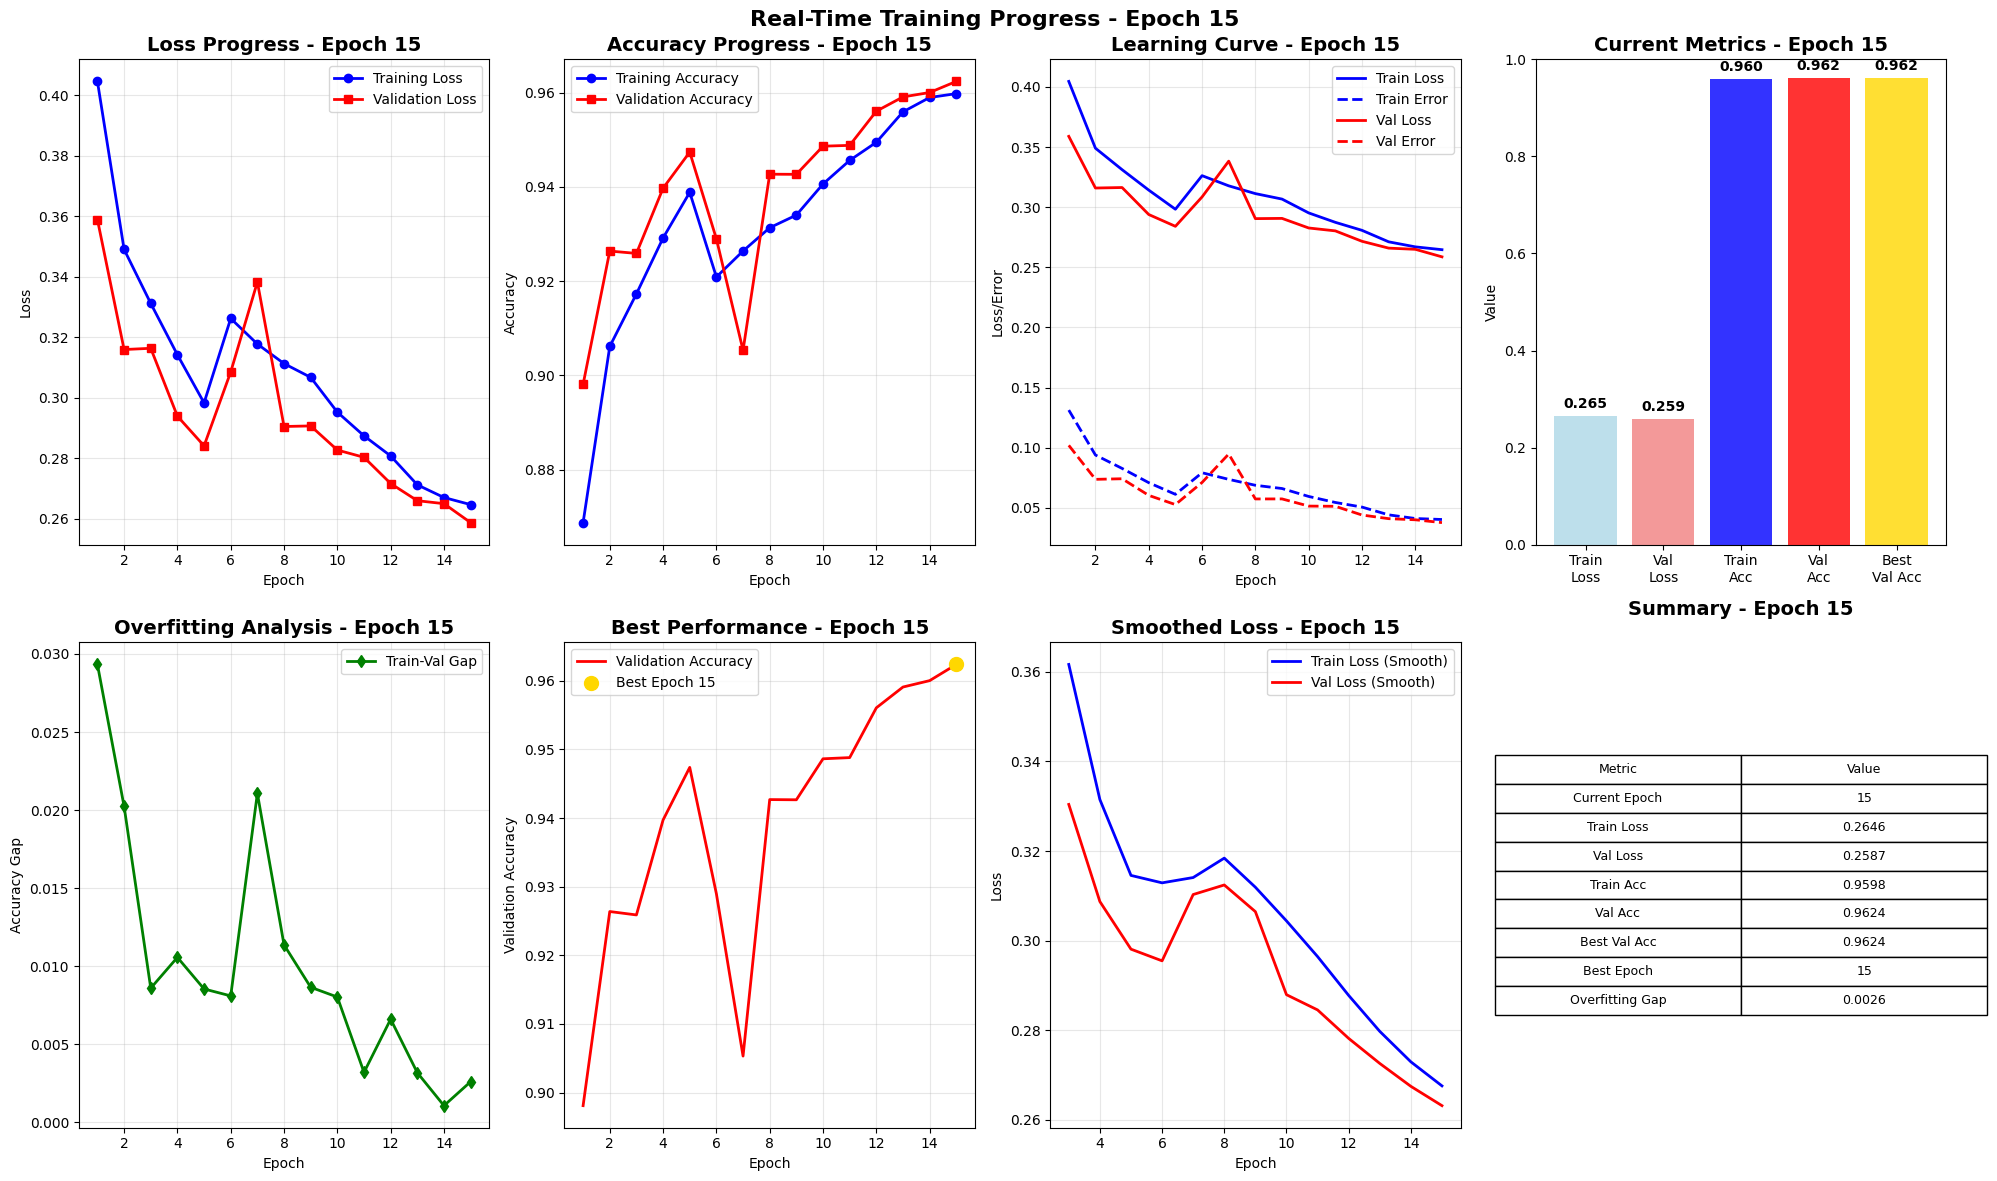


EPOCH 15 DETAILED SUMMARY
📊 Current Performance:
   Training Loss:     0.264645
   Validation Loss:   0.258691
   Training Accuracy: 0.959781 (95.98%)
   Validation Accuracy: 0.962374 (96.24%)
🏆 Best Performance:
   Best Val Accuracy: 0.962374 (96.24%)
   Best Epoch:        15
📈 Training Analysis:
   Overfitting Gap:   0.002593
   Loss Improvement:  ✓
   Acc Improvement:   ✓
Training completed! Best validation accuracy: 0.9624
Fold 1 completed - Best Val Acc: 0.9624

Fold 2/5
----------------------------------------
Starting enhanced training for 15 epochs...
Model parameters: 66,147,651
Trainable parameters: 25,202,947
Epoch [1/15], Batch [0/4293], Loss: 1.1380, Acc: 0.3750, LR: 0.001000
Epoch [1/15], Batch [20/4293], Loss: 0.6247, Acc: 0.6161, LR: 0.001000
Epoch [1/15], Batch [40/4293], Loss: 0.6959, Acc: 0.6463, LR: 0.001000
Epoch [1/15], Batch [60/4293], Loss: 0.5270, Acc: 0.6670, LR: 0.001000
Epoch [1/15], Batch [80/4293], Loss: 0.5988, Acc: 0.6863, LR: 0.001000
Epoch [1/15], Bat

In [ ]:
results = main_enhanced(quick_mode=False, use_cross_validation=True)